# Group Connection Testing

In [41]:
import pymaid
import logging
import pandas as pd
import numpy as np
import csv
import networkx as nx
import itertools
import seaborn as sns
from networkx import from_pandas_adjacency
from itertools import chain, combinations
from matplotlib import pyplot as plt
from collections import namedtuple
from graspologic.inference import group_connection_test
from pkg.platy import _get_folder, load_annotations

In [2]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [4]:
folder = _get_folder()
annotations = load_annotations()
annotations

,skids,side,class,segment,type,group
0,1343291,rc,NaN,head,NaN,NaN
1,1332516,rc,s,head,49.0,NaN
2,1402724,rc,NaN,3,NaN,NaN
3,1462664,rc,NaN,2,NaN,NaN
4,84457,rc,NaN,head,NaN,NaN
...,...,...,...,...,...,...
9192,2256298,NaN,NaN,1,NaN,NaN
9193,2256326,NaN,NaN,1,NaN,NaN
9194,2256339,NaN,NaN,1,NaN,NaN
9195,1602239,NaN,NaN,1,NaN,NaN


In [32]:
#get skids for l, r, head, pygidium, 0, 1, 2, 3

skids_hemis = {"l": [], "r": []}
skids_segs = {"head": [], "pygidium": [], "0": [], "1": [], "2": [], "3": []}
labels_hemis = {"l": [], "r": []}
labels_segs = {"head": [], "pygidium": [], "0": [], "1": [], "2": [], "3": []}
poss_labels = ["s", "i", "m"]

#add skids and labels for hemis
for key in skids_hemis:
    for i in range(len(annotations["skids"])):
        if(annotations["side"][i]==key and annotations["class"][i] in poss_labels):
            skids_hemis[key].append(annotations["skids"][i])
            labels_hemis[key].append(annotations["class"][i])

#add skids and labels for segments
for key in skids_segs:
    for i in range(len(annotations["skids"])):
        if(annotations["segment"][i]==key and annotations["class"][i] in poss_labels):
            skids_segs[key].append(annotations["skids"][i])
            labels_segs[key].append(annotations["class"][i])

In [40]:
#comparison for hemis
count_hemis = {"l" : {"s": 0, "i": 0, "m": 0}, "r": {"s": 0, "i": 0, "m": 0}}

for key in count_hemis:
    for i in range(len(labels_hemis[key])):
        count_hemis[key][labels_hemis[key][i]] += 1

# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "s", "i", "m"
list_counts = []
class_label = []
hemi_label = []
for key in count_hemis:
    for inner_key in count_hemis[key]:
        class_label.append(inner_key)
        list_counts.append(count_hemis[key][inner_key])
        hemi_label.append(key)


label_counts = list(zip(class_label, list_counts, hemi_label))
df = pd.DataFrame(label_counts, columns = ["class", "count", "side"])

['s', 'i', 'm', 's', 'i', 'm']
[506, 669, 115, 468, 704, 127]
['l', 'l', 'l', 'r', 'r', 'r']


,class,count,side
0,s,506,l
1,i,669,l
2,m,115,l
3,s,468,r
4,i,704,r
5,m,127,r


<AxesSubplot:xlabel='class', ylabel='count'>

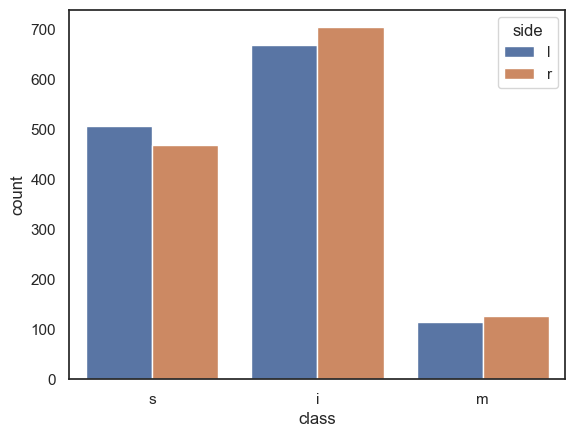

In [42]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="side", data=df)

In [6]:
skids_left = pymaid.get_skids_by_annotation("left")
skids_right = pymaid.get_skids_by_annotation("right")
skids_head = pymaid.get_skids_by_annotation("head")
skids_pygidium = pymaid.get_skids_by_annotation("pygidium")
skids_0 = pymaid.get_skids_by_annotation("segment_0")
skids_1 = pymaid.get_skids_by_annotation("segment_1")
skids_2 = pymaid.get_skids_by_annotation("segment_2")
skids_3 = pymaid.get_skids_by_annotation("segment_3")

In [7]:
#don't think i need this
df_left = pymaid.adjacency_matrix(skids_left)
df_right = pymaid.adjacency_matrix(skids_right)
df_head = pymaid.adjacency_matrix(skids_head)
df_pygidium = pymaid.adjacency_matrix(skids_pygidium)
df_0 = pymaid.adjacency_matrix(skids_0)
df_1 = pymaid.adjacency_matrix(skids_1)
df_2 = pymaid.adjacency_matrix(skids_2)
df_3 = pymaid.adjacency_matrix(skids_3)

In [8]:
skids_sensory = pymaid.get_skids_by_annotation("Sensory neuron")
skids_inter = pymaid.get_skids_by_annotation("interneuron")
skids_motor = pymaid.get_skids_by_annotation("motorneuron")

In [9]:
def class_labels(skids, skids_sensory, skids_inter, skids_motor):
    new_skids = []
    labels = []
    for i, skid in enumerate(skids):
        if skid in skids_sensory:
            labels.append("s")
            new_skids.append(skid)
        elif skid in skids_inter:
            labels.append("i")
            new_skids.append(skid)
        elif skid in skids_motor:
            labels.append("m")
            new_skids.append(skid)

    return new_skids, labels

In [10]:
left_new, left_labels = class_labels(skids_left, skids_sensory, skids_inter, skids_motor)
right_new, right_labels = class_labels(skids_right, skids_sensory, skids_inter, skids_motor)
head_new, head_labels = class_labels(skids_head, skids_sensory, skids_inter, skids_motor)
pygidium_new, pygidium_labels = class_labels(skids_pygidium, skids_sensory, skids_inter, skids_motor)
seg0_new, seg0_labels = class_labels(skids_0, skids_sensory, skids_inter, skids_motor)
seg1_new, seg1_labels = class_labels(skids_1, skids_sensory, skids_inter, skids_motor)
seg2_new, seg2_labels = class_labels(skids_2, skids_sensory, skids_inter, skids_motor)
seg3_new, seg3_labels = class_labels(skids_3, skids_sensory, skids_inter, skids_motor)
len(seg0_new)

91

In [11]:
df_left = pymaid.adjacency_matrix(left_new)
df_right = pymaid.adjacency_matrix(right_new)
df_head = pymaid.adjacency_matrix(head_new)
df_pygidium = pymaid.adjacency_matrix(pygidium_new)
df_0 = pymaid.adjacency_matrix(seg0_new)
df_1 = pymaid.adjacency_matrix(seg1_new)
df_2 = pymaid.adjacency_matrix(seg2_new)
df_3 = pymaid.adjacency_matrix(seg3_new)

In [12]:
left_adj = df_left.to_numpy()
right_adj = df_right.to_numpy()
head_adj = df_head.to_numpy()
pygidium_adj = df_pygidium.to_numpy()
seg0_adj = df_0.to_numpy()
seg1_adj = df_1.to_numpy()
seg2_adj = df_2.to_numpy()
seg3_adj = df_3.to_numpy()

In [13]:
all_adjs = [left_adj, right_adj, head_adj, pygidium_adj, seg0_adj, seg1_adj, seg2_adj, seg3_adj]
pairwise_adjs = list(itertools.combinations(all_adjs, 2))
len(pairwise_adjs)

28

In [15]:
stat, pval, misc = group_connection_test(left_adj, right_adj, left_labels, right_labels)
pval

0.012503805183485778